# Stress Classifier
## Overview
1. [Select Database](#1-select-database)
2. [Import Libraries and Load Useful Utilities](#2-import-libraries-and-load-useful-utilities)
3. [Data Extraction](#3-data-extraction): Downloads and sorts through databases.
4. [Pre-processing](#4-pre-processing): filtering and signal cleaning.
5. [Feature Extraction](#5-feature-extraction): R-R peaks, PQRST peaks, EDR, in addition to mean, kurtosis etc.
6. [Feature Selection](#6-feature-selection): Visualise labelled feature distribution, select desired labels etc.
7. [Traditional Machine Learning Methods](#7-traditional-machine-learning-methods): Linear classification including Random Forests, LDA, Bagged Trees and linear/non-linear SVM.
8. [Convolutional Neural Network](#8-convolutional-neural-network): 1-D convolutional neural network with automatic feature extraction 

## 1. Select Database
Select between:
* [Spider-Fearful ECG](https://doi.org/10.1371/journal.pone.0231517) 
* BrainPatch ECG

In [44]:
#DATABASE = 'Spider'
DATABASE = 'BrainPatch'

## 2. Import Libraries and Load Useful Utilities
Please run `pip install -r requirements.txt` first

In [45]:
# Import necessary modules
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB, GaussianNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

import math
import os
import time
import sys
import subprocess
import warnings
from itertools import product
from typing import List
import IPython.display as display

In [46]:
# Useful Utilities
class Utilities():
    def __init__(self):    
        pass

    def progress_bar(current_message, current, total, bar_length=20):
        fraction = current / total
        arrow = int(fraction * bar_length - 1) * '-' + '>'
        padding = int(bar_length - len(arrow)) * ' '
        ending = '\n' if current == total else '\r'
        print(f'{current_message}: [{arrow}{padding}] {int(fraction*100)}%', end=ending)


    def check_csv_exists(folder_path, sample_index):
        # read the CSV file into a dataframe and append to the list
        filename = os.path.join(folder_path, f'df_{index}.csv')
        try:
            df = pd.read_csv(filename)
        except FileNotFoundError:
            return False
        return filename


    def load_dataframe(filename):
        # read the CSV file into a dataframe and append to the list
        df = pd.read_csv(filename)
        return df
    

    def save_dataframe_list(list_of_dfs:List[pd.DataFrame], folder_path:str, file_name:str):
        # create directoy if necessary
        os.makedirs(folder_path, exist_ok=True) 
        for i, df in enumerate(list_of_dfs):
            file_path = f"{folder_path}/{file_name}_{i}.csv"
            df.to_csv(file_path, index=False)


    def save_dataframe(df:pd.DataFrame, folder_path:str, file_name:str):
        print(f"Saving Dataframe to: {folder_path}/{file_name}.csv...", end='')
        # create directoy if necessary
        os.makedirs(folder_path, exist_ok=True) 
        df.to_csv(f'{folder_path}/{file_name}.csv', index=False)
        print("Saved.")

In [47]:
# For bigger plots
plt.rcParams['figure.figsize'] = [20, 12]  
plt.rcParams['font.size'] = 14

## 3. Data Extraction
* Downloads data, normalizes timeframe, attaches labels, and saves sorted data.

In [48]:
# This class handles downloading and sorting the Spider database.
# Method from this paper https://doi.org/10.1371/journal.pone.0231517
class SpiderDataExtraction():
    def __init__(self, directory):
        self.directory = directory + 'Spider'
        self.sampling_frequency = 100
        self.sorted_ECG = pd.DataFrame(columns=['Timestamp', 'ECG', 'Stress Level'])

    
    # Downloads and extracts database 
    def download_data(self):
        if sys.platform == 'linux':
            url = 'https://physionet.org/files/ecg-spider-clip/1.0.0/'
            print("Downloading database...this may take a while")
            os.makedirs(self.directory, exist_ok=True)
            cmd = f"wget -r -N -c -np -P {self.directory} {url}"
            subprocess.run(cmd)
        else:
            sys.exit("Unable to download database. If you are running Windows/Mac please download manually via https://physionet.org/content/ecg-spider-clip/1.0.0/")
    

    # sorts data from each participant, labelling each ECG recording and appends to one dataframe.
    # Following the SB approach in the study.
    def sort_data(self):       
        directory = self.directory + '/physionet.org/files/ecg-spider-clip/1.0.0/'
        
        # Exclude VP70 because of noise
        sub_directories = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
                'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
                'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP71','VP72','VP73','VP74',
                'VP75','VP76','VP77','VP78','VP79','VP80']
        
        # Path to Ratings file for all particpants
        subjective_ratings_file = f'{self.directory}/Subjective Ratings.txt'

        # Read in the subject ratings file (ignore arousal markers, interested in angst)
        ratings_df = (
            pd.read_csv(subjective_ratings_file, sep='\t', names=['Subject','Group','Session', '4', '8', '12', '16', 'NA1', 'NA2', 'NA3', 'NA4'], encoding='UTF-16')
            .drop(columns=['NA1', 'NA2', 'NA3', 'NA4'])
            .iloc[1:]
            .reset_index(drop=True)
            .astype(int)
        )

        for index, sub_directory in enumerate(sub_directories):
            Utilities.progress_bar('Sorting database', index, len(sub_directories)-1)

            # set participant data paths
            ECG_file = f'{directory}{sub_directory}/BitalinoECG.txt'
            triggers_file = f'{directory}{sub_directory}/Triggers.txt'

            # Get participant number
            participant_no = int(sub_directory[2:])

            # read in particpant ECG raw data file and reorder to get columns Timestamp, ECG 
            raw_df = pd.read_csv(ECG_file, sep='\t', names = ['ECG','Timestamp','NA'])
            raw_df = raw_df.drop(columns=['NA'])
            raw_df = raw_df[['Timestamp', 'ECG']]
            
            # Read in participant trigger file
            triggers_df = pd.read_csv(triggers_file, sep='\t', names = ['Clip','On','Off'])

            # Determine stress levels by correspoding the raw ecg data with the triggers file and the Subjective Ratings file.
            # Iterate through the 16 stress clips (first clip is a demo):
            for i in range(1, 17):
                # Determine row in ratings file
                row = ratings_df.loc[ratings_df['Subject'] == participant_no].index[0]

                # find stress for the clip in the ratings file
                stress_level = ratings_df.iloc[row]['4'] if i <= 4 else ratings_df.iloc[row]['8'] if i <= 8 else ratings_df.iloc[row]['12'] if i <= 12 else ratings_df.iloc[row]['16']

                # convert stress level to Low, Medium or High (1-3)
                stress_level = 2 if (stress_level <= 2) else 3

                # Get 60 second slice of ECG data for that clip
                clip_start_time = triggers_df.iloc[i]['On']
                start_index = raw_df.index[raw_df['Timestamp']>clip_start_time].tolist()[0]
                clip_df = raw_df.iloc[start_index:start_index + (self.sampling_frequency * 60)].copy(deep=False)
                clip_df['Stress Level'] = stress_level
                self.sorted_ECG = pd.concat([self.sorted_ECG, clip_df], axis=0, ignore_index=True)

            # Add the last 3 minute resting phase (stress level Low) to the data
            rest_start_time = triggers_df.iloc[-1]['On']
            start_index = (raw_df['Timestamp'] > rest_start_time).idxmin() + (self.sampling_frequency * 120)
            rest_df = raw_df.iloc[start_index: start_index + (self.sampling_frequency * 180)].copy(deep=False)
            rest_df.loc[:, 'Stress Level'] = 1
            self.sorted_ECG = pd.concat([self.sorted_ECG, rest_df], axis=0, ignore_index=True)



In [49]:
# This class handles sorting through the data collected using the BrainPatch ECG Recorder.
class BPDataExtraction():
    def __init__(self, directory):
        self.directory = directory + 'BrainPatch/'
        self.sorted_ECG = pd.DataFrame(columns=['Timestamp', 'ECG', 'Stress Level'])

    
    # interpolates data to achieve sampling rate
    def interpolate(self, sample:pd.DataFrame) -> pd.DataFrame:
        # convert timestamp column to a NumPy array
        timestamps = sample['Timestamp'].to_numpy()

        # calculate the time difference between each pair of adjacent timestamps
        time_diff = np.diff(timestamps)

        # calculate the average sampling rate of the data
        sampling_frequency = (1 / np.mean(time_diff))*1e6

        interpolated_sample = pd.DataFrame(columns=['Timestamp', 'ECG'])

        # interpolate the data to obtain desired sampling rate
        interpolated_sample['ECG'] = nk.signal_resample(sample['ECG'], sampling_rate=sampling_frequency, desired_sampling_rate=self.sampling_frequency)
        time_interval_us = (1/self.sampling_frequency)*1e6
        interpolated_sample['Timestamp'] = [i*time_interval_us for i in range(len(interpolated_sample['ECG']))]

        return interpolated_sample.astype('int64')


    # define a function to map stress levels to labels
    def map_stress_level(self, level):
        if level >= 7:
            return 3
        elif level >= 5:
            return 2
        else:
            return 1


     # Sorts data from each participant, interpolates it (downsampling), labelling each ECG recording and appends to one dataframe.
    def sort_data(self, sampling_frequency:int=1000):
        self.sampling_frequency = sampling_frequency
        # list the contents of the directory and filter out subfolders
        recordings = [f for f in os.listdir(self.directory) if os.path.isfile(os.path.join(self.directory, f))]

        for index, recording in enumerate(recordings):
            Utilities.progress_bar('Sorting database', index, len(recordings)-1)
            # get recording number
            split_string = recording.split(' ')
            second_element = split_string[1]
            second_split = second_element.split('.')
            recording_number = int(second_split[0])

            # extract recording dataframe
            recording_df = pd.read_csv(self.directory + recording, skiprows=2, usecols=[0, 1], header=None, names=['Timestamp', 'ECG'])
            # interpolate it to desired sampling frequency
            recording_df = self.interpolate(recording_df)
            # load events containing the stress level markers
            events_df = pd.read_csv(self.directory + 'Events/Events.csv')
            # extract events for that recording
            events_df = events_df[events_df['Recording No'] == recording_number].dropna(how='all', axis=1)
            # convert string values to datetime objects
            events_df['Timestamp'] = pd.to_datetime(events_df['Timestamp'], format='%H:%M')
            # normalise timestamps 
            events_df['Timestamp'] = events_df['Timestamp'] - events_df['Timestamp'].iloc[0]
            # convert from nanoseconds to microseconds
            events_df['Timestamp'] = (events_df['Timestamp']/ 1e3).astype('int64')
            # label recording with Events label
            recording_df = pd.merge_asof(recording_df, events_df, on='Timestamp', direction='backward')
            recording_df = recording_df.drop('Recording No', axis=1)
            # convert stress level to Low(1-4), Medium(5-6) or High(7-10)
            recording_df['Stress Level'] = recording_df['Stress Level'].apply(self.map_stress_level)
            # concatentate to main dataframe
            self.sorted_ECG = pd.concat([self.sorted_ECG, recording_df], axis=0, ignore_index=True)

In [50]:
data_path = '/data/myenv/Data/'

if DATABASE == 'Spider':
    sde = SpiderDataExtraction(data_path)
    # sde.download_data()
    sde.sort_data()
    dataframe_path = f'{data_path}Spider/Dataframes'
    Utilities.save_dataframe(sde.sorted_ECG, dataframe_path, 'Sorted')

elif DATABASE == 'BrainPatch':
    bpde = BPDataExtraction(data_path)
    bpde.sort_data(sampling_frequency=1000) # downsamples to 1kHz
    dataframe_path = f'{data_path}BrainPatch/Dataframes'
    Utilities.save_dataframe(bpde.sorted_ECG, dataframe_path, 'Sorted')

Sorting database: [------------------->] 100%
Saving Dataframe to: /data/myenv/Data/BrainPatch/Dataframes/Sorted.csv...Saved.


## 4. Pre-Processing
* Interpolates data to sample rate using timestamps 
* Semgents data using rolling window with overlap
* Cleans data using Neurokit's 5th Order Butterworth filter.

In [51]:
class PreProcessing():
    def __init__(self, sorted_ECG:pd.DataFrame, sampling_frequency:int):
        self.sorted_ECG = sorted_ECG
        self.sampling_frequency = sampling_frequency
       

    # segments data with overlap using rolling window, if semgnet_heartbeats true, then segment is centralised around the heartbeat (R peak)
    def segment(self, window_length_s:float, overlap:float, segment_hearbeats=False):
        # convert window_length in seconds to samples
        self.window_samples = int(window_length_s * self.sampling_frequency)
        # Calculate the step_size as the fraction of the total window samples
        step_size = int(self.window_samples * (1-overlap)) 

        # Initialize starting variables
        current_index = 0
        current_stressed = self.sorted_ECG['Stress Level'][current_index]
        self.preprocessed_ECG = pd.DataFrame(columns=['Timestamp', 'ECG', 'Stress Level'])

        # faster to concatenate at the end 
        preprocessed_ECG_list = []

        # get all R peaks index if required
        if segment_hearbeats:
            r_peaks = nk.ecg_peaks(self.sorted_ECG['ECG'], sampling_rate=self.sampling_frequency)
        
        # Loop through the entire dataframe
        while current_index < len(self.sorted_ECG['ECG']):  
            Utilities.progress_bar('Segmenting data', current_index, len(self.sorted_ECG))
            # calculate end index in window and exit if out of bounds          
            end_index = current_index + self.window_samples
            if (end_index > len(self.sorted_ECG['ECG'])):
                break
            
            # Check if the window overlaps a different label
            end_stressed = self.sorted_ECG['Stress Level'][end_index]

            # If the next window has a different label, skip to next start of next label
            if end_stressed != current_stressed:
                while (current_stressed == self.sorted_ECG['Stress Level'][current_index]):
                    current_index += 1
                current_stressed = end_stressed

            # otherwise, add segment to list of pre-processed ECG
            else:
                if segment_hearbeats:
                    # get index of next r peak
                    while not bool(r_peaks[0]['ECG_R_Peaks'][current_index]):
                        current_index += 1
                    # append segment centred on r-peak to dataframe
                    preprocessed_ECG_list.append(self.sorted_ECG.iloc[(current_index - (self.window_samples//2)):(current_index + (self.window_samples//2))].astype('Float64'))
                    # shift the window to next non r-peak index
                    current_index += 1
                else:
                    # append segment to dataframe
                    preprocessed_ECG_list.append(self.sorted_ECG.iloc[current_index:current_index + self.window_samples].astype('Float64'))
                    # Shift the window
                    current_index += step_size
            
        self.preprocessed_ECG = pd.concat(preprocessed_ECG_list, axis=0, ignore_index=True).astype('Float64')
        Utilities.progress_bar('Segmenting data', current_index, current_index)
    
    
    def create_2d(self):
        # convert the pandas DataFrame into a 2D pandas where each row has the size of window and the corresponding label (stress level)
        # self.preprocessed_ECG_2d = self.preprocessed_ECG.groupby(self.preprocessed_ECG.index // self.window_samples).apply(lambda x: pd.Series({'ECG': x['ECG'].values, 'Stress Level': x['Stress Level'].values[0]}))
        
        # Calculate the number of rows required
        num_rows = len(self.preprocessed_ECG['ECG']) // self.window_samples

        # Create an empty dataframe to hold the reshaped data
        df_reshaped = pd.DataFrame(index=range(num_rows), columns=[f"ECG {i}" for i in range(self.window_samples)])

        # Reshape the data
        for i in range(num_rows):
            start_idx = i * self.window_samples
            end_idx = (i + 1) * self.window_samples
            values = self.preprocessed_ECG['ECG'].iloc[start_idx:end_idx].values
            df_reshaped.iloc[i, :] = values
        
        self.preprocessed_ECG_2d = df_reshaped
        self.preprocessed_ECG_2d['Stress Level'] = self.preprocessed_ECG['Stress Level'][::self.window_samples].reset_index(drop=True)


    def clean(self):
        # Clean each sample in the stressed and not stressed data (overwrites original data)
        # using method 'neurokit' (0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering) but can be changed to other cleaning methods
        print("Cleaning data...")
        self.preprocessed_ECG['ECG'] = pd.Series(nk.ecg_clean(self.preprocessed_ECG['ECG'], self.sampling_frequency, method='neurokit')).astype('Float64')

In [52]:
window_length_s = 30 # window length for each segment
overlap = 0.1 # overlap for sliding window

if DATABASE == 'Spider':
    pp = PreProcessing(sde.sorted_ECG, sde.sampling_frequency)
    pp.segment(window_length_s, overlap)
    pp.clean()
    Utilities.save_dataframe(pp.preprocessed_ECG, dataframe_path, 'Preprocessed')

elif DATABASE == 'BrainPatch':
    pp = PreProcessing(bpde.sorted_ECG, bpde.sampling_frequency) # the data will be downsampled to 1000Hz
    pp.segment(window_length_s, overlap)
    pp.clean()
    Utilities.save_dataframe(pp.preprocessed_ECG, dataframe_path, 'Preprocessed')


Segmenting data: [------------------->] 100%
Cleaning data...
Saving Dataframe to: /data/myenv/Data/BrainPatch/Dataframes/Preprocessed.csv...Saved.


## 5. Feature Extraction
* Extracts features such as HRV time, frequency and non-linear domain, EDR etc.

In [53]:
# Main class that extracts features from a dictionary of sorted dataframes and stores to csv
class FeatureExtraction():
    # takes in cleaned ECG data
    def __init__(self, preprocessed_ECG:pd.DataFrame, window_samples:int, sampling_frequency:int):
        self.preprocessed_ECG = preprocessed_ECG
        self.window_samples = window_samples
        self.sampling_frequency = sampling_frequency
        self.feature_extracted_ECG = pd.DataFrame()


    def plot_segment(self, segment, ECG_processed=None, peaks=None, colors=['r', 'g', 'c', 'm', 'y', 'k']):
        # Define time array
        t = np.arange(len(segment)) / self.sampling_frequency

        # plot fft if no peaks are given
        if isinstance(peaks, type(None)):
            # Compute FFT
            fft = np.fft.fft(segment)
            freq = np.fft.fftfreq(len(segment), d=1/self.sampling_frequency)

            # max frequency to plot
            max_freq = 100

            # Filter out negative frequencies and frequencies above max_freq
            mask = (freq >= 0) & (freq <= max_freq)
            freq = freq[mask]
            fft = fft[mask]

            # Calculate PSD
            psd = ((np.abs(fft) ** 2) / len(segment))
            psd = 10 * np.log10(psd)
            psd -= psd.max()

            # Plot raw ECG segment
            fig, ax = plt.subplots()
            ax.plot(t, segment)

            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude')

            # Hide y-axis units
            ax.set_yticklabels([])

            # Crop the plot to the first 25% of the x-axis
            ax.set_xlim(t.max()*0, t.max()*0.25)

            # Add subplot
            subax = fig.add_axes([0.68, 0.65, 0.2, 0.2])
            subax.plot(freq, psd)

            # Limit x-axis to positive frequencies between 0 and max_freq
            subax.set_xlim(0, max_freq)

            # add labels
            subax.set_xlabel('Frequency (Hz)')
            subax.set_ylabel('PSD (dB)')

        # otherwise, plot peaks
        else:
            # Plot raw ECG segment
            plt.figure()
            plt.plot(t, segment)

            # Create Line2D objects for each peak type with corresponding color
            lines = [Line2D([0], [0], linestyle='--', color=colors[i]) for i in range(len(peaks))]

            # Plot peaks
            for i, peak in enumerate(peaks):
                peak_inds = np.where(ECG_processed[peak] == 1)[0]
                for ind in peak_inds:
                    plt.axvline(x=t[ind], linestyle='--', color=colors[i])

            # Add legend with the created Line2D objects and corresponding labels
            plt.legend(handles=lines, labels=peaks, loc='lower right')

            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            # Hide y-axis units
            plt.gca().set_yticklabels([])
            # Crop the plot to the first 25% of the x-axis
            plt.xlim(t.max()*0, t.max()*0.1)

            # Show plot
            plt.show()


    def wave_analysis(self, segment:pd.DataFrame, plot=False) -> pd.DataFrame:
        ECG_processed, info = nk.ecg_process(segment.to_numpy(dtype='float64'), sampling_rate=self.sampling_frequency, method='neurokit')

        # calculate the mean and SD of the peak intervals
        peaks = ['ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_R_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks']
        # Minimum and maximum expected HR (beats per min)
        min_HR = 30
        max_HR = 200
        min_interval = 60e6/max_HR
        max_interval = 60e6/min_HR

        df = pd.DataFrame()
        for peak in peaks:
            intervals = np.diff(np.where(np.array(ECG_processed[peak]==1))) * self.sampling_frequency
            # Remove any intervals that are out of range
            intervals = intervals[(intervals >= min_interval) & (intervals <= max_interval)]

            df[f'{peak}_Interval_Mean'] = [np.mean(intervals)]
            df[f'{peak}_Interval_SD'] = [np.std(intervals)]
        
        if plot:
            self.plot_segment(segment, ECG_processed, peaks)

        # calculate the average length of each wave
        waves = ['P', 'R', 'T']
        max_duration = [120000, 120000, 200000]
        for w, wave in enumerate(waves):
            onsets = np.where(np.array(ECG_processed[f'ECG_{wave}_Onsets']==1))[0]
            offsets = np.where(np.array(ECG_processed[f'ECG_{wave}_Offsets']==1))[0]
            # find index of first element in offsets that is >= first element in onsets
            idx_offset = np.where(offsets >= onsets[0])[0][0]
            # find size of smallest array
            duration_size = min(onsets.size, offsets.size)
            # slice offsets array to start at same index as onset
            offsets = offsets[idx_offset:duration_size]
            # set onset to same length
            onsets = onsets[:duration_size]
            # calculate durations taking into account missed onset detection
            durations = []
            # iterate over elements of both arrays
            i = 0
            j = 0
            while i < len(offsets) and j < len(onsets):
                diff = offsets[i] - onsets[j]
                if diff < 0:
                    i += 1
                else:
                    durations.append(diff)
                    i += 1
                    j += 1
            durations = np.array(durations * self.sampling_frequency)
            # Remove any intervals that are out of range
            durations = durations[(durations <= max_duration[w])]

            duration_mean = np.mean(durations)
            duration_SD = np.std(durations)
            df[f'ECG_{wave}_Duration_Mean'] = duration_mean
            df[f'ECG_{wave}_Duration_SD'] = duration_SD

        wave_onsets_offsets = []
        for wave in waves:
            wave_onsets_offsets.append(f'ECG_{wave}_Onsets')
            wave_onsets_offsets.append(f'ECG_{wave}_Offsets')
        
        if plot:
            self.plot_segment(segment, ECG_processed, wave_onsets_offsets, colors = ['r', 'r', 'g', 'g', 'b', 'b'])

        return df    

    
    def calc_PSD(self, segment:pd.DataFrame) -> pd.DataFrame:
        # Sum the power across 10 Hz bands from 0 to 200 Hz
        # Compute the power spectrum using a Fast Fourier Transform
        PSD = nk.signal_psd(segment.to_list(), sampling_rate=self.sampling_frequency, method="welch", min_frequency=0.5, max_frequency=200)
        # Create an empty list to store the binned power values
        binned_power = []
        # Set the initial frequency and bin range values
        frequency = 0
        bin_range = 10
        nyquist_frequency = self.sampling_frequency//2

        # Loop through the frequency ranges of 10Hz
        while bin_range <= nyquist_frequency:
            # Initialize the total power for the current bin
            total_power = 0
            
            # Loop through the rows of the original dataframe
            for index, row in PSD.iterrows():
                # Check if the frequency falls within the current bin range
                if row['Frequency'] >= frequency and row['Frequency'] < bin_range:
                    # Add the power value to the total power
                    total_power += row['Power']
            
            # Calculate the logarithm of the total power for the current bin and append it to the binned_power list
            if total_power > 0:
                binned_power.append(np.log10(total_power))
            else:
                binned_power.append(-np.inf)
            
            # Increment the frequency and bin range values for the next iteration
            frequency += 10
            bin_range += 10

        # Create a new dataframe with the binned power values and the frequency ranges as the index
        binned_PSD = pd.DataFrame({'Power': binned_power})
        binned_PSD['Frequency Band'] = list(range(10, nyquist_frequency+1, 10))
        # Convert to columns
        ECG_Frequencies = pd.DataFrame(columns=[f"ECG_FQ_{i}" for i in range(10, nyquist_frequency+10, 10)])
        for i, column in enumerate(ECG_Frequencies.columns):
            ECG_Frequencies[column] = [binned_PSD.iloc[i]['Power']]
        
        return ECG_Frequencies
    

    def calc_collective_ECG_features(self) -> pd.DataFrame:
        print("Extracting Collective Features...")
        warnings.filterwarnings('ignore') # temporarily supress warnings
        # automated pipeline for preprocessing an ECG signal
        ECG_processed, info = nk.ecg_process(self.preprocessed_ECG['ECG'].to_numpy(dtype='float64'), sampling_rate=self.sampling_frequency, method='neurokit')
        events = np.arange(self.window_samples, self.preprocessed_ECG.shape[0], self.window_samples)
        epochs = nk.epochs_create(ECG_processed, events=events, sampling_rate=self.sampling_frequency)
        # calculate ECG Features such as pqrstu intevals etc.
        ECG_events = nk.ecg_analyze(epochs, sampling_rate=self.sampling_frequency, method='event-related')
        warnings.filterwarnings('default')
        return ECG_events

    
    def calc_HRV_features(self, r_peaks_df, segment):
        np.seterr(divide="ignore", invalid="ignore")
        # skip segment if insufficient peaks are detected (otherwise will cause NK error)
        if int(r_peaks_df[r_peaks_df == 1].sum().iloc[0]) < 4:
            return

        # Extract HRV features from R-R peaks, see https://neuropsychology.github.io/NeuroKit/functions/hrv.html 
        # compute HRV - time, frequency and nonlinear indices.
        warnings.filterwarnings('ignore') # temporarily supress warnings
        HRV_time = nk.hrv_time(r_peaks_df, sampling_rate=self.sampling_frequency, show=show_plot)
        HRV_frequency = nk.hrv_frequency(r_peaks_df, sampling_rate=self.sampling_frequency, show=show_plot)
        warnings.filterwarnings('default')

        # compute Shannon Entropy (SE) using signal symbolization and discretization
        # see https://neuropsychology.github.io/NeuroKit/functions/complexity.html#entropy-shannon 
        SE = nk.entropy_shannon(segment, symbolize='A')[0]
        HRV_ShanEn = pd.DataFrame([SE], columns=['HRV_ShanEn'])
        # concat to feature dataframe
        return HRV_time, HRV_frequency, HRV_ShanEn

    
    def calc_EDR(self, r_peaks_df, segment, show_plot) -> pd.DataFrame:
        # Get ECG Derived Respiration (EDR) and add to the data
        warnings.filterwarnings('ignore') # temporarily supress warnings
        ecg_rate = nk.signal_rate(r_peaks_df, sampling_rate=self.sampling_frequency, desired_length=len(r_peaks_df))
        warnings.filterwarnings('default')
        EDR_sample = nk.ecg_rsp(ecg_rate, sampling_rate=self.sampling_frequency)
        if show_plot:
            nk.signal_plot(segment)
            nk.signal_plot(EDR_sample)
        EDR_Distance = pd.DataFrame([np.average(nk.signal_findpeaks(EDR_sample)["Distance"])], columns=['EDR_Distance'])

        return EDR_Distance


    # Main method to extracts features from ECG using neurokit
    def extract(self, ECG:bool=False, EDR:bool=False, show_plot:bool=False):
        # collective epoch analysis
        if ECG:
           ECG_events = self.calc_collective_ECG_features()

        # individual epoch analysis
        sample_index = 0
        epoch_index = 0
        while sample_index < (len(self.preprocessed_ECG['ECG']) - self.window_samples):
            Utilities.progress_bar('Extracting Individual Features', sample_index, len(self.preprocessed_ECG['ECG']))

            # get segment ECG and stress level from dataframe 
            segment = self.preprocessed_ECG.iloc[sample_index:sample_index + self.window_samples]['ECG']
            stress_level = self.preprocessed_ECG.iloc[sample_index]['Stress Level']
            features = pd.DataFrame({'Stress Level': [stress_level]})
            # extract R-R peaks
            r_peaks_df = nk.ecg_peaks(segment, sampling_rate=self.sampling_frequency, correct_artifacts=True)[0]
            
            sample_index += self.window_samples

            if ECG:
                warnings.filterwarnings('ignore') # temporarily supress warnings
                ECG_processed_segment, info = nk.ecg_process(segment.to_numpy(dtype='float64'), sampling_rate=self.sampling_frequency, method='neurokit')
                if show_plot:
                    # nk.ecg_plot(ECG_processed_segment)
                    self.plot_segment(segment)

                # Calculate ECG_HRV - different heart rate variability metrices.
                HRV_intervals = nk.ecg_intervalrelated(ECG_processed_segment, sampling_rate=self.sampling_frequency)

                # calculate waveform intervals (PQRSTU)
                ECG_intervals = self.wave_analysis(segment, show_plot)

                # get the binned power spectrum frequencies from the ECG segment
                ECG_frequencies = self.calc_PSD(segment)
                
                # add ECG_event to dataframe (ECG Features such as pqrstu intevals etc.))
                ECG_event = ECG_events.iloc[epoch_index].to_frame().transpose().reset_index()
                ECG_event = ECG_event.drop(['index', 'Label', 'Event_Onset'], axis=1)
                epoch_index += 1

                # concat to dataframe
                features = pd.concat([features, HRV_intervals, ECG_intervals, ECG_frequencies], axis=1) #ECG_event

            else:
                # If not all ECG features desired, obtain HRV and Shannon Entropy
                HRV_time, HRV_frequency, HRV_ShanEn = self.calc_HRV_features(r_peaks_df, segment)
                # concat to feature dataframe
                features = pd.concat([features, HRV_time, HRV_frequency, HRV_ShanEn], axis=1)
                
            if EDR:
                EDR_Distance = self.calc_EDR(r_peaks_df, segment, show_plot)
                # concat to dataframe
                features = pd.concat([features, EDR_Distance], axis=1)

            # concat features to main dataframe
            self.feature_extracted_ECG = pd.concat([self.feature_extracted_ECG, features], axis=0, ignore_index=True)
        Utilities.progress_bar('Extracting Neurokit Features', sample_index, sample_index)

In [54]:
if False:
    print(DATABASE)
    fe = FeatureExtraction(pp.preprocessed_ECG, pp.window_samples, pp.sampling_frequency)
    fe.extract(ECG=True, EDR=True, show_plot=False)
    Utilities.save_dataframe(fe.feature_extracted_ECG, dataframe_path, 'Feature Extracted BP HRV_ECG_EDA_30s')

## 6. Feature Selection:
* Select desired features, sanity check the values, and save them to Features directory
* Visualise most feature and cross-feature distribution 

In [55]:
# Each feature will be an object of FEParameter
class FEParameter:
    def __init__(self, name:str, min:float=-999999, max:float=999999):
        self.name = name
        self.min = min
        self.max = max

In [56]:
# Define FeatureSelection class that is used to visualise and select data
class FeatureSelection():
    def __init__(self, feature_extracted_ECG):
        self.feature_extracted_ECG = feature_extracted_ECG


    # desired_features is a list of FEParameter objects  
    def select(self, desired_features:List[FEParameter]):
        self.selected_features_ECG = self.feature_extracted_ECG[['Stress Level']]
        
        for feature in desired_features:
            out_of_range_count = 0
            # Sanity check: check if feature exists
            if feature.name in self.feature_extracted_ECG.columns:
                # Set value to NaN if it falls outside min and max values.
                for i, value in enumerate(self.feature_extracted_ECG[feature.name]):
                    if (value < feature.min) or (value > feature.max):
                        out_of_range_count += 1
                        self.feature_extracted_ECG.loc[i, feature.name] = np.nan
                # Add column to new selected features
                pd.options.mode.chained_assignment = None
                self.selected_features_ECG[feature.name] = self.feature_extracted_ECG[[feature.name]].copy()
                pd.options.mode.chained_assignment = 'warn'
            else:
                print(f'Error: No such feature "{feature}" in extracted features')
            if out_of_range_count != 0:
                print(f'Feature: {feature.name} is out of range {out_of_range_count}/{len(self.feature_extracted_ECG[feature.name])} segments')

        
    # impute missing values in dataset with mean values of column
    def impute(self):
        # switch infs to NaNs
        pd.options.mode.chained_assignment = None
        self.selected_features_ECG.replace([np.inf, -np.inf], np.nan, inplace=True)
        pd.options.mode.chained_assignment = 'warn'
        # check for columns with only NaNs and delete if necessary 
        drop_cols = [col for col in self.selected_features_ECG.columns if self.selected_features_ECG[col].isnull().all()]
        if drop_cols:
            self.selected_features_ECG = self.selected_features_ECG.drop(drop_cols, axis=1)
        imp = SimpleImputer(strategy='mean')
        imp.fit(self.selected_features_ECG)
        self.selected_features_ECG = pd.DataFrame(imp.transform(self.selected_features_ECG), columns=self.selected_features_ECG.columns)


    def visualise(self, plot_type='pairplot'):
        print("Generating plot...")
        if plot_type == 'pairplot':         
            sns.pairplot(data = self.selected_features_ECG, hue='Stress Level', palette=['green', 'yellow', 'red'])
        elif plot_type == 'kdeplot':
            # Create a figure with subplots for each feature
            subplot_size = math.ceil(math.sqrt(len(self.selected_features_ECG.columns)))
            fig = plt.figure(figsize=(20, 8*subplot_size))

            # Loop through each feature and add it to a subplot
            for i, feature in enumerate(self.selected_features_ECG):
                fig.add_subplot(subplot_size, subplot_size, i+1)
                sns.kdeplot(x=feature, data=self.selected_features_ECG, hue='Stress Level', common_norm=False, warn_singular=False, palette=['green', 'yellow', 'red'])
            plt.show()
        else:
            print("Plot type not recognised. Please choose between pairplot, kdeplot")

In [57]:
# Desired Features to be selected from Feature Extracted ECG.
# See Neurokit2 HRV for more information - https://neuropsychology.github.io/NeuroKit/functions/hrv.html

# Minimum and maximum expected HR (beats per min)
min_HR = 30
max_HR = 200

# MinNN: The minimum of the RR intervals (Parent, 2019; Subramaniam, 2022).
HRV_MinNN = FEParameter('HRV_MinNN', min=60000.0/max_HR, max=60000.0/min_HR)
# MaxNN: The maximum of the RR intervals (Parent, 2019; Subramaniam, 2022).
HRV_MaxNN = FEParameter('HRV_MaxNN', min=60000.0/max_HR, max=60000.0/min_HR)
# MeanNN: The mean of the RR intervals.
HRV_MeanNN = FEParameter('HRV_MeanNN', min=60000.0/max_HR, max=60000.0/min_HR)


# pNN20: The proportion of RR intervals greater than 20ms, out of the total number of RR intervals.
HRV_pNN20 = FEParameter('HRV_pNN20')
# pNN50: The proportion of RR intervals greater than 50ms, out of the total number of RR intervals.
HRV_pNN50 = FEParameter('HRV_pNN50')
# A geometrical parameter of the HRV, or more specifically, the baseline width of the RR intervals distribution 
# TINN: obtained by triangular interpolation, where the error of least squares determines the triangle. 
# It is an approximation of the RR interval distribution.
HRV_TINN = FEParameter('HRV_TINN')
# HTI: The HRV triangular index, measuring the total number of RR intervals divided by the height of the RR intervals histogram.
HRV_HTI = FEParameter('HRV_HTI')

# VLF: The spectral power (W/Hz) of very low frequencies (.0033 to .04 Hz).
HRV_VLF = FEParameter('HRV_VLF', min=0.0, max=9) # hidden due to use of 0.5 Hz high-pass butterworth filter
# LF: The spectral power (W/Hz) of low frequencies (.04 to .15 Hz).
HRV_LF = FEParameter('HRV_LF', max=1.00)
# HF: The spectral power (W/Hz) of high frequencies (.15 to .4 Hz).
HRV_HF = FEParameter('HRV_HF', max=1.00)
# LFHF: The ratio obtained by dividing the low frequency power by the high frequency power.
HRV_LFHF = FEParameter('HRV_LFHF', max=1.00)

# SDNN: The standard deviation of the RR intervals.
# See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/ for chosen max value.
HRV_SDNN = FEParameter('HRV_SDNN', max=200)
# RMSSD: The square root of the mean of the squared successive differences between adjacent RR intervals. 
# # It is equivalent (although on another scale) to SD1, and therefore it is redundant to report correlations with both (Ciccone, 2017).
# See https://help.welltory.com/en/articles/4413231-what-normal-ranges-and-measurement-standards-we-use-to-interpret-your-heart-rate-variability for chosen max value.
HRV_RMSSD = FEParameter('HRV_RMSSD', max=200)
# The root mean square of successive differences (RMSSD) divided by the mean of the RR intervals (MeanNN).
cv_foldsSD = FEParameter('HRV_cv_foldsSD')
# Shannon Entropy
HRV_ShanEn = FEParameter('HRV_ShanEn')
# Sample Entropy
HRV_SampEn = FEParameter('HRV_SampEn')
# DFA_alpha1: The monofractal detrended fluctuation analysis of the HR signal, corresponding to short-term correlations.
HRV_DFA_alpha1 = FEParameter('HRV_DFA_alpha1')

# ECG Intervals and Durations
parameter_names = ['ECG_S_Peaks_Interval_Mean',
                   'ECG_S_Peaks_Interval_SD',
                   'ECG_T_Peaks_Interval_Mean',
                   'ECG_T_Peaks_Interval_SD',
                   'ECG_P_Duration_Mean',
                   'ECG_P_Duration_SD',
                   'ECG_T_Duration_Mean',
                   'ECG_T_Duration_SD']

# create new objects for each parameter name
ECG_duration_intervals = []
for name in parameter_names:
    parameter = FEParameter(name)
    ECG_duration_intervals.append(parameter)

# PSD
parameter_names = ['ECG_FQ_10', 'ECG_FQ_20', 'ECG_FQ_30', 'ECG_FQ_40', 'ECG_FQ_50', 'ECG_FQ_60', 'ECG_FQ_70', 'ECG_FQ_80', 'ECG_FQ_90', 'ECG_FQ_100', 'ECG_FQ_110', 'ECG_FQ_120', 'ECG_FQ_130', 'ECG_FQ_140', 'ECG_FQ_150', 'ECG_FQ_160', 'ECG_FQ_170', 'ECG_FQ_180', 'ECG_FQ_190', 'ECG_FQ_200', 'ECG_FQ_210']
ECG_PSD = []
for name in parameter_names:
    parameter = FEParameter(name)
    ECG_PSD.append(parameter)


# EDR Distance: Breathing interval measured in ms.
# Breathing rate range is approximately 12 to 25 per minute - see https://my.clevelandclinic.org/health/articles/10881-vital-signs
EDR_Distance = FEParameter('EDR_Distance', min=2000, max=4167)

In [58]:
# fs = FeatureSelection(fe.feature_extracted_ECG)
fs = FeatureSelection(Utilities.load_dataframe(f'{dataframe_path}/Feature Extracted HRV_ECG_EDA_30s.csv'))

''' Select Desired features for classification: '''
# HRV
selected_features = [HRV_MinNN, HRV_MaxNN, HRV_MeanNN, HRV_SDNN, HRV_RMSSD, HRV_ShanEn, HRV_DFA_alpha1, HRV_pNN20, HRV_pNN50] 
# Intervals and Durations
selected_features.extend(ECG_duration_intervals)
# PSD
selected_features.extend(ECG_PSD)
# EDR
selected_features.append(EDR_Distance)


fs.select(selected_features)
fs.impute()
#fs.visualise(plot_type='kdeplot')
#fs.visualise(plot_type='pairplot')
Utilities.save_dataframe(fs.selected_features_ECG, dataframe_path, 'Feature Selected')

Feature: HRV_MaxNN is out of range 1/1213 segments
Feature: HRV_SDNN is out of range 20/1213 segments
Feature: HRV_RMSSD is out of range 13/1213 segments
Feature: ECG_S_Peaks_Interval_Mean is out of range 702/1213 segments
Feature: ECG_T_Peaks_Interval_Mean is out of range 716/1213 segments
Feature: EDR_Distance is out of range 805/1213 segments
Saving Dataframe to: /data/myenv/Data/BrainPatch/Dataframes/Feature Selected.csv...Saved.


## 7. Traditional Machine Learning Methods
* Prepares data by randomly splitting data into train, test and validation data
* Option for Linear Discriminant Analysis (LDA) for dimension reduction
* Implements the following classification models, with methods for tuning: LDA, Random Forests

In [59]:
# Structure of dataset that will be passed to Models as object
class Dataset():
    def __init__(self, X, y, X_train, y_train, X_test, y_test, sss, num_of_labels):
        self.X = X
        self.y = y
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.sss = sss
        self.num_of_labels = num_of_labels

In [68]:
# Utilities for preparing and evaluating classification
class ML_Utilities():  
    # corrects imbalanced dataset using SMOTE, and splits into n_splitted stratified shuffle split .
    def prepare(selected_features_ECG:pd.DataFrame, num_of_labels, test_size:float, n_splits:int,  normalise=True) -> Dataset:     
        # remove medium labels for binary classification
        if num_of_labels == 2:
            selected_features_ECG = selected_features_ECG[selected_features_ECG['Stress Level'] != 2.0]

        y = selected_features_ECG['Stress Level']
        X = selected_features_ECG.loc[:, selected_features_ECG.columns != 'Stress Level']

        # L2 normalization for each feature (if required)
        if normalise:
            X_normalized = pd.DataFrame(normalize(X.values, norm='l2', axis=0), columns=X.columns)
            # Scale the values to be between 0 and 1 with MinMaxScaler
            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X_normalized)
            # Replace X with the scaled values
            X = pd.DataFrame(X_scaled, columns=X.columns)

        print("Before imbalanced label correction (SMOTE):")
        low = y.value_counts()[1.0]/len(y)*100
        print(f'    Low Stress in dataset: {low:.2f}%')
        if num_of_labels == 3:
            medium = y.value_counts()[2.0]/len(y)*100
            print(f'    Medium Stress in dataset: {medium:.2f}%')
        high = y.value_counts()[3.0]/len(y)*100
        print(f'    High Stress in dataset: {high:.2f}%')
        
        # SMOTE class rebalance
        X, y = SMOTE(sampling_strategy='not majority').fit_resample(X, y)

        # Split the data into training and test sets
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=15)
        
        # Obtain the training and testing sets for the first fold
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            break

        X_train = X_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        # create data structure
        dataset = Dataset(X, y, X_train, y_train, X_test, y_test, sss, num_of_labels)
        return dataset


    def plot_confustion_matrix(num_of_labels, y_test=0, y_pred=0, cm=0):
        display_labels = ['Low', 'High'] if (num_of_labels==2) else ['Low', 'Medium', 'High']
        # Confusion Matrix
        if isinstance(cm, int):
            ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=display_labels, normalize='true')
        else:
            default_font_size = plt.rcParams['font.size']
            plt.rcParams.update({'font.size': default_font_size * 1.4})
            disp = ConfusionMatrixDisplay(cm, display_labels=display_labels)
            disp.plot(values_format='.2f')
            plt.show()
            plt.rcParams.update({'font.size': default_font_size})

In [61]:
class PlotLearning(Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label='Train ' + metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='Test ' + metric)
            axs[i].legend()
            axs[i].grid()
            axs[i].set_xlabel('Epochs')
            if metric == 'accuracy':
                axs[i].set_ylabel('Classification ' + metric.capitalize() + ' (%)')
                axs[i].set_ylim([0,1])
            elif metric == 'loss':
                axs[i].set_ylabel('Classification ' + metric.capitalize())

        plt.tight_layout()
        plt.show()

In [94]:
# Define Traditional Machine Learning class, which implements different linear and non linear classification methods
class Traditional_ML():
    def __init__(self, dataset_binary:Dataset, dataset_three_level:Dataset, database, number_of_cores:int=1):
        self.dataset_binary = dataset_binary
        self.dataset_three_level = dataset_three_level
        self.database = database
        self.n_jobs = number_of_cores
        self.model = 'RF'

    # main tune method
    def tune(self):
        if self.model == 'NB':
            tuning_func = lambda: self.NB_tuner()
        elif self.model == 'SVM':
            tuning_func = lambda: self.SVM_tuner()
        elif self.model == 'RF':
            tuning_func = lambda: self.RF_tuner()
        else:
            raise ValueError(f'Unsupported model: {self.model}')
        tuning_func()


    # main classification method
    def classify(self):
        if self.model == 'NB':
            tuning_func = lambda: self.NB_classifier()
        elif self.model == 'SVM':
            tuning_func = lambda: self.SVM_classifier()
        elif self.model == 'RF':
            tuning_func = lambda: self.RF_classifier()
        else:
            raise ValueError(f'Unsupported model: {self.model}')
        tuning_func()


    def evaluate(self, model, dataset:Dataset, plot_CM=True):
        # Cross-validation using Stratified ShuffleSplit 
        # Initialize the accuracy and confusion matrix lists that will be averaged
        accuracies = []
        confusion_matrices = []
        thr_acc = []
        tmr_acc = []
        tlr_acc = []
        run_times = []
        for train_index, test_index in dataset.sss.split(dataset.X, dataset.y):
            # Split into train / test data using the SSS as a guide
            X_train, X_test = dataset.X.iloc[train_index], dataset.X.iloc[test_index]
            y_train, y_test = dataset.y.iloc[train_index], dataset.y.iloc[test_index]

            # Fit the classifier to the training data
            model.fit(X_train, y_train)

            # Predict on the testing data and calculate run-time
            start_time = time.time()
            y_pred = model.predict(X_test)
            end_time = time.time()
            run_times.append(end_time-start_time)

            # Calculate the accuracy and append to the list
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)
            thr_acc.append(accuracy_score(y_test[y_test == 3.0], y_pred[y_test == 3.0]) * 100)
            if dataset.num_of_labels == 3:
                tmr_acc.append(accuracy_score(y_test[y_test == 2.0], y_pred[y_test == 2.0]) * 100)
            tlr_acc.append(accuracy_score(y_test[y_test == 1.0], y_pred[y_test == 1.0]) * 100)

            # Calculate the confusion matrix and append to the list
            cm = confusion_matrix(y_test, y_pred, normalize='true')
            confusion_matrices.append(cm)

        # Calculate the mean and standard deviation of the accuracy across all splits
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)

        print(f"Mean Accuracy for {dataset.num_of_labels} level classification: {mean_accuracy:.3f} +/- {std_accuracy:.3f}")

        # print results
        print(f"    Accuracy for True High Rate (THR): {np.mean(thr_acc):.2f}%")
        if dataset.num_of_labels == 3:
            print(f"    Accuracy for True Medium Rate (TMR): {np.mean(tmr_acc):.2f}%")
        print(f"    Accuracy for True Low Rate (TLR): {np.mean(tlr_acc):.2f}%")
        print(f"    Average run-time: {np.mean(run_times)}")

        # Calculate the average confusion matrix
        mean_cm = np.mean(confusion_matrices, axis=0)

        # Calculate precision, recall, and F1 score
        precision = np.diag(mean_cm) / np.sum(mean_cm, axis=0)
        recall = np.diag(mean_cm) / np.sum(mean_cm, axis=1)
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Print the average F1 score
        print(f"    Average F1 Score: {np.mean(f1_score)}")

        # plot confusion matrix if desired
        if plot_CM:
            ML_Utilities.plot_confustion_matrix(dataset.num_of_labels, cm=mean_cm)

        # return as percentage
        return mean_accuracy*100, std_accuracy*100
        

    # Naive Bayes Classifier
    def NB_tuner(self):
        print("\nNaive Bayes Classifier:")

        # calculate training class probabilities for Gaussian NB
        low = self.dataset_three_level.y_train.value_counts()[1.0]/len(self.dataset_three_level.y_train)
        if self.dataset_three_level.num_of_labels == 3:
            medium = self.dataset_three_level.y_train.value_counts()[2.0]/len(self.dataset_three_level.y_train)
        high = self.dataset_three_level.y_train.value_counts()[3.0]/len(self.dataset_three_level.y_train)
        Gaussian_priors = [low, medium, high] if self.dataset_three_level.num_of_labels == 3 else [low, high]

        # create a dictionary of classifiers
        classifiers = {'Multinomial': MultinomialNB(),
                       'Bernoulli': BernoulliNB(),
                       'Complement': ComplementNB(),
                       'Gaussian': GaussianNB()}
        
        # set up a parameter grid for each classifier
        param_grids = {'Multinomial': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
                       'Bernoulli': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
                                     'binarize': [0.0, 0.5, 1.0]},
                       'Complement': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
                        'Gaussian': {'priors': [Gaussian_priors]}
                       }

        accuracies_binary = []
        std_devs_binary = []
        accuracies_three = []
        std_devs_three = []
        for name, nb in classifiers.items():
            # perform a grid search to find the best hyperparameters for each classifier
            grid_search = GridSearchCV(nb, param_grid=param_grids[name])
            grid_search.fit(self.dataset_three_level.X_train, self.dataset_three_level.y_train)

            # print the best hyperparameters for each classifier
            print('\nBest hyperparameters for {}: {}'.format(name, grid_search.best_params_))

            # perform a 5 fold cross validation using the best grid search for both 2 and 3 level classification
            accuracy, std_dev = self.evaluate(grid_search.best_estimator_, dataset=self.dataset_three_level, plot_CM=True)
            accuracies_three.append(accuracy)
            std_devs_three.append(std_dev)
            if name == 'Gaussian':
                grid_search.best_estimator_.priors = [0.5,0.5]
            accuracy, std_dev = self.evaluate(grid_search.best_estimator_, dataset=self.dataset_binary, plot_CM=True)
            accuracies_binary.append(accuracy)
            std_devs_binary.append(std_dev)

        # Set the width of each bar
        bar_width = 0.35

        # Set the positions of the bars on the x-axis
        r1 = np.arange(len(classifiers.keys()))
        r2 = [x + bar_width for x in r1]

        # Create the bar chart
        plt.bar(r1, accuracies_binary, width=bar_width, color='paleturquoise', yerr=std_devs_binary, capsize=5, label='Binary classification')
        plt.bar(r2, accuracies_three, width=bar_width, color='darkslategray', yerr=std_devs_three, capsize=5, label='Three-level classification')

        # Add labels, title, and legend
        plt.xlabel('Classifier')
        plt.xticks([r + bar_width/2 for r in range(len(classifiers.keys()))], classifiers.keys())
        plt.ylabel('Accuracy (%)')
        plt.ylim([0, 100])
        plt.legend()

        # Show the bar chart
        plt.show()


    # Post tuned Naive Bayes Classifer
    def NB_classifier(self):
        # binary classification
        low = self.dataset_binary.y_train.value_counts()[1.0]/len(self.dataset_binary.y_train)
        high = self.dataset_binary.y_train.value_counts()[3.0]/len(self.dataset_binary.y_train)
        Gaussian_priors = [low, high]
        nb = GaussianNB(priors=Gaussian_priors)
        self.evaluate(nb, self.dataset_binary) 

        # three-level classification
        low = self.dataset_three_level.y_train.value_counts()[1.0]/len(self.dataset_three_level.y_train)
        medium = self.dataset_three_level.y_train.value_counts()[2.0]/len(self.dataset_three_level.y_train)
        high = self.dataset_three_level.y_train.value_counts()[3.0]/len(self.dataset_three_level.y_train)
        Gaussian_priors = [low, medium, high]
        nb = GaussianNB(priors=Gaussian_priors)
        self.evaluate(nb, self.dataset_three_level)
        

    # Support Vector Machine Classifier 
    def SVM_tuner(self):
        print("\nSVM Classifier:")
        
        # create a dictionary of kernels
        kernels = {'Linear': 'linear',
                   'Polynomial': 'poly',
                   'Radial basis function': 'rbf',
                   'Sigmoid': 'sigmoid'}
        
        # set up a parameter grid for each kernel
        param_grids = {'Linear': {'C': [0.1, 1, 10, 100, 1000]},
                       'Polynomial': {'C': [0.1, 1, 10, 100, 1000],
                                      'degree': [2, 3, 4],
                                      'gamma': [0.1, 0.01]},
                       'Radial basis function': {'C': [0.1, 1, 10, 100, 1000],
                                                 'gamma': [0.1, 0.01, 0.001]},
                       'Sigmoid': {'C': [0.1, 1, 10, 100, 1000],
                                    'gamma': [0.1, 0.01, 0.001],
                                    'coef0': [0.1, 0.01, 0.001]}
                      }

        accuracies_binary = []
        std_devs_binary = []
        accuracies_three = []
        std_devs_three = []
        dataset = self.dataset_three_level
        for name, kernel in kernels.items():
            # perform a grid search to find the best hyperparameters for each kernel
            grid_search = GridSearchCV(SVC(kernel=kernel), param_grid=param_grids[name], n_jobs=self.n_jobs)
            grid_search.fit(dataset.X_train, dataset.y_train)

            # print the best hyperparameters for each kernel
            print('\nBest hyperparameters for {}: {}'.format(name, grid_search.best_params_))

            # perform a 5 fold cross validation using the best grid search for both 2 and 3 level classification
            accuracy, std_dev = self.evaluate(grid_search.best_estimator_, dataset=self.dataset_three_level, plot_CM=True)
            accuracies_three.append(accuracy)
            std_devs_three.append(std_dev)
            accuracy, std_dev = self.evaluate(grid_search.best_estimator_, dataset=self.dataset_binary, plot_CM=True)
            accuracies_binary.append(accuracy)
            std_devs_binary.append(std_dev)

        # Set the width of each bar
        bar_width = 0.35

        # Set the positions of the bars on the x-axis
        r1 = np.arange(len(kernels.keys()))
        r2 = [x + bar_width for x in r1]

        # Create the bar chart
        plt.bar(r1, accuracies_binary, width=bar_width, color='lightsalmon', yerr=std_devs_binary, capsize=5, label='Binary classification')
        plt.bar(r2, accuracies_three, width=bar_width, color='orangered', yerr=std_devs_three, capsize=5, label='Three-level classification')

        # Add labels, title, and legend
        plt.xlabel('Classifier')
        plt.xticks([r + bar_width/2 for r in range(len(kernels.keys()))], kernels.keys())
        plt.ylabel('Accuracy (%)')
        plt.ylim([0, 100])
        plt.legend()

        # Show the bar chart
        plt.show()


    # Post-tuned Support Vector Machine Classifier 
    def SVM_classifier(self):
        # binary classification
        svm = SVC(kernel='rbf', C=1000, gamma=0.1, random_state=15)
        self.evaluate(svm, self.dataset_binary) 

        # three-level classification
        svm = SVC(kernel='poly', C=1000, degree=4, gamma=0.1, random_state=15)
        self.evaluate(svm, self.dataset_three_level) 

    
    # Random Forest Tuner
    def RF_tuner(self):
        print("\nRandom Forest Classifier:")
        
        # define the criterion options
        criterions = {'Gini Index': 'gini',
                    'Entropy': 'entropy',
                    'Logarithmic Loss': 'log_loss'}

        # define the parameter grid
        param_grid = {'n_estimators': [10, 50, 100, 250, 500],
                    'max_depth': [None, 2, 3, 4, 5, 7],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': [1, 'sqrt', 'log2', None],
                    'bootstrap': [True, False]}

        accuracies_binary = []
        std_devs_binary = []
        accuracies_three = []
        std_devs_three = []
        dataset = self.dataset_three_level

        for name, criterion in criterions.items():
            # create a random forest classifier with the current criterion
            rf = RandomForestClassifier(criterion=criterion)

            # perform a grid search to find the best hyperparameters for the classifier
            grid_search = GridSearchCV(rf, param_grid=param_grid, n_jobs=self.n_jobs)
            grid_search.fit(dataset.X_train, dataset.y_train)

            # print the best hyperparameters for the classifier
            print('\nBest hyperparameters for {}: {}'.format(name, grid_search.best_params_))

            # evaluate the classifier on the test set
            accuracy, std_dev = self.evaluate(grid_search.best_estimator_, dataset=self.dataset_three_level, plot_CM=True)
            accuracies_three.append(accuracy)
            std_devs_three.append(std_dev)
            accuracy, std_dev = self.evaluate(grid_search.best_estimator_, dataset=self.dataset_binary, plot_CM=True)
            accuracies_binary.append(accuracy)
            std_devs_binary.append(std_dev)

        # Set the width of each bar
        bar_width = 0.35

        # Set the positions of the bars on the x-axis
        r1 = np.arange(len(criterions.keys()))
        r2 = [x + bar_width for x in r1]

        # Create the bar chart
        plt.bar(r1, accuracies_binary, width=bar_width, color='greenyellow', yerr=std_devs_binary, capsize=5, label='Binary classification')
        plt.bar(r2, accuracies_three, width=bar_width, color='forestgreen', yerr=std_devs_three, capsize=5, label='Three-level classification')

        # Add labels, title, and legend
        plt.xlabel('Criterion')
        plt.xticks([r + bar_width/2 for r in range(len(criterions.keys()))], criterions.keys())
        plt.ylabel('Accuracy (%)')
        plt.ylim([0, 100])
        plt.legend()

        # Show the bar chart
        plt.show()


    # Post-tuned Random Forest Classifier
    def RF_classifier(self):
        params = {'criterion': 'gini', 'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
        rf = RandomForestClassifier(**params, random_state=15)

        # binary classification
        self.evaluate(rf, self.dataset_binary) 

        # three-level classification
        self.evaluate(rf, self.dataset_three_level) 

Before imbalanced label correction (SMOTE):
    Low Stress in dataset: 49.79%
    High Stress in dataset: 50.21%
Before imbalanced label correction (SMOTE):
    Low Stress in dataset: 19.37%
    Medium Stress in dataset: 61.09%
    High Stress in dataset: 19.54%
Mean Accuracy for 2 level classification: 0.863 +/- 0.011
    Accuracy for True High Rate (THR): 84.34%
    Accuracy for True Low Rate (TLR): 88.21%
    Average run-time: 0.01082158088684082
    Average F1 Score: 0.8626833452174834


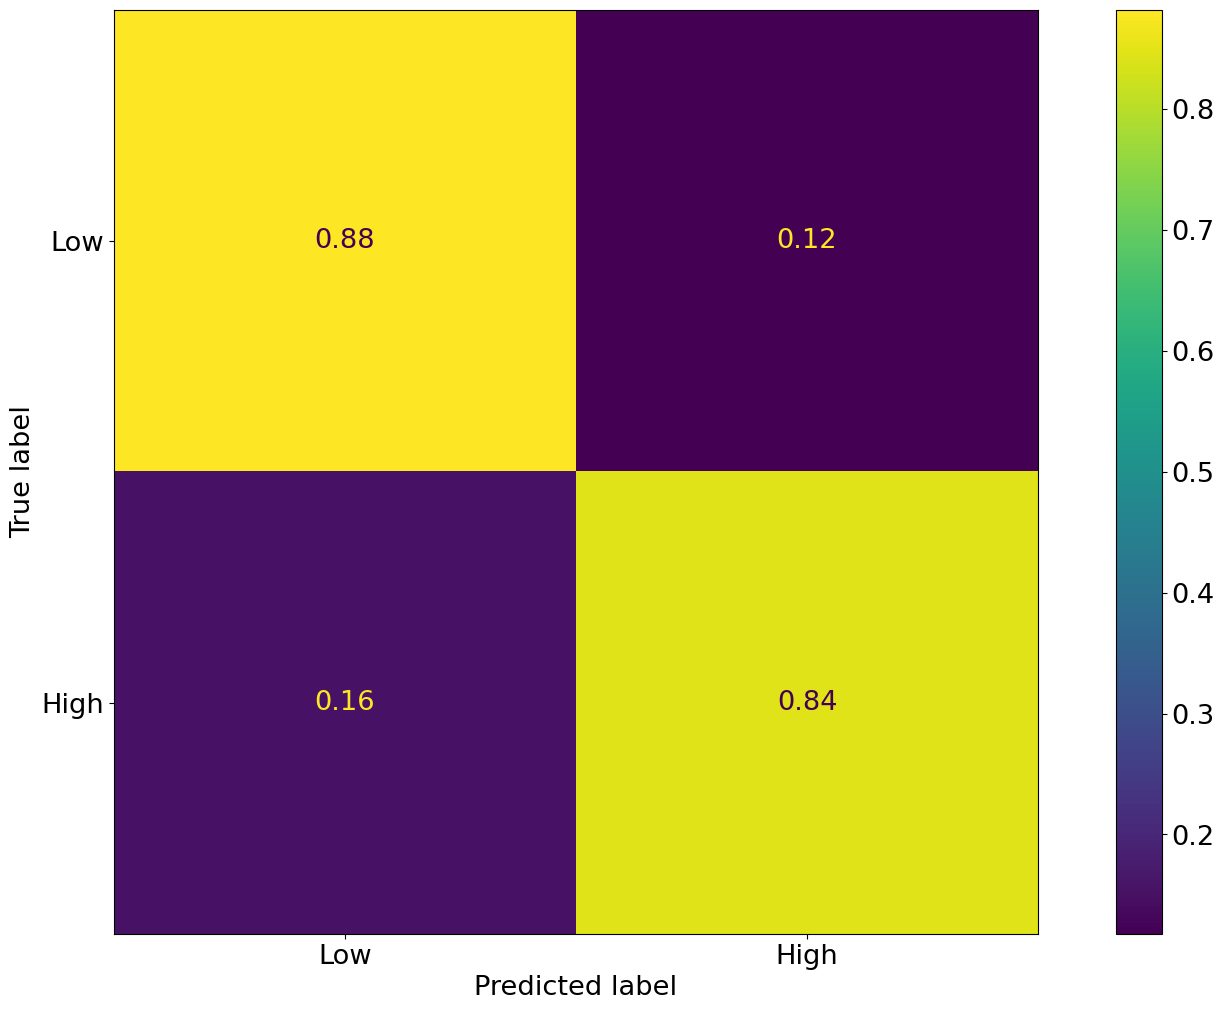

Mean Accuracy for 3 level classification: 0.891 +/- 0.013
    Accuracy for True High Rate (THR): 91.99%
    Accuracy for True Medium Rate (TMR): 81.26%
    Accuracy for True Low Rate (TLR): 94.08%
    Average run-time: 0.01560211181640625
    Average F1 Score: 0.8902605372002496


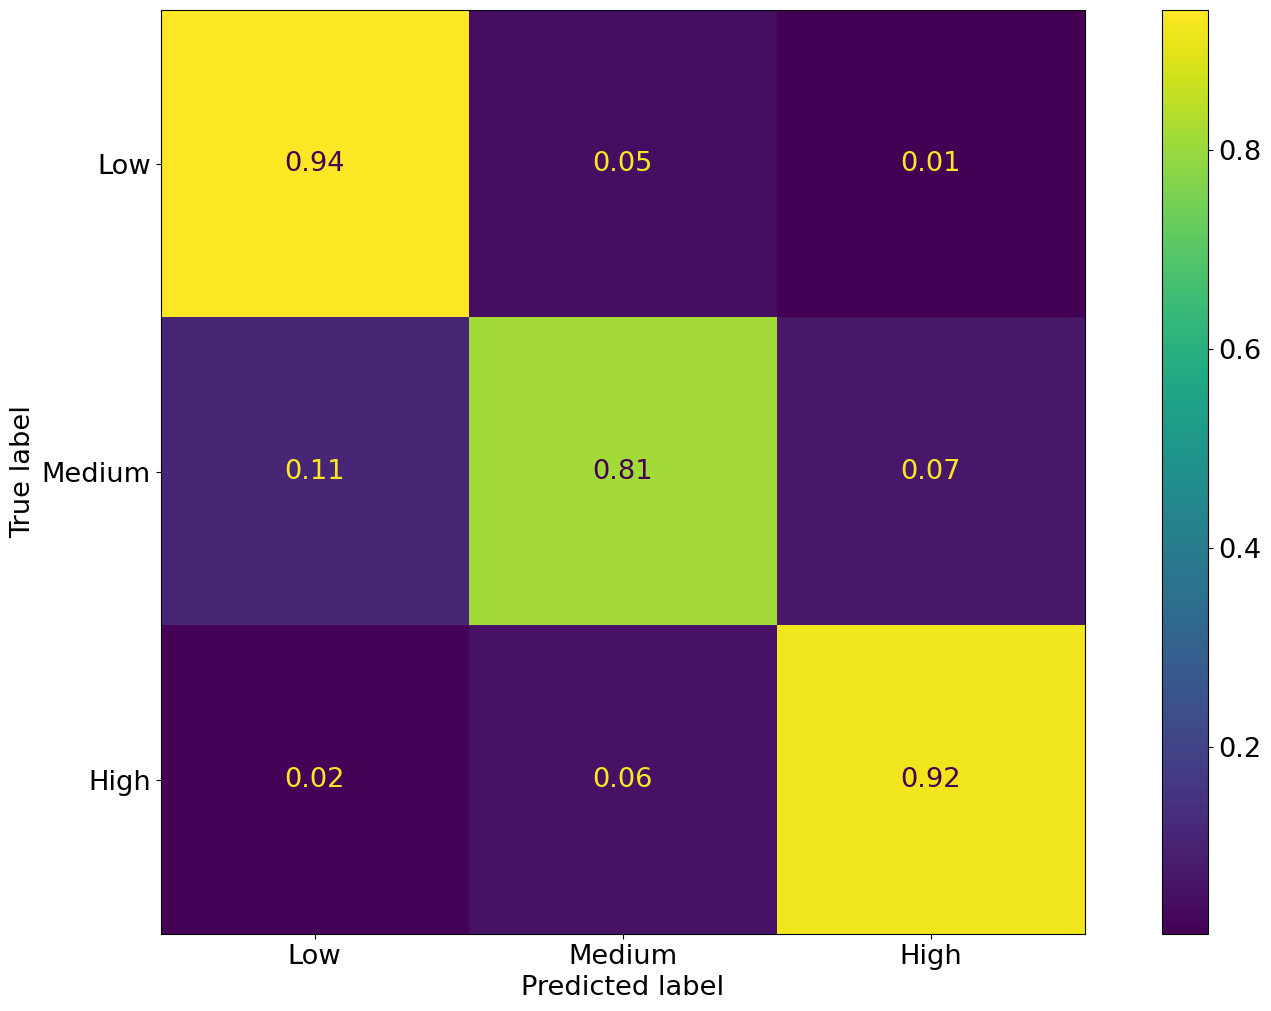

In [95]:
selected_features_ECG = Utilities.load_dataframe(f'{dataframe_path}/Feature Selected.csv')

# make two datasets - binary and three-level classification
dataset_binary = ML_Utilities.prepare(selected_features_ECG, num_of_labels=2, test_size=0.30, n_splits=5, normalise=True)
dataset_three_level = ML_Utilities.prepare(selected_features_ECG, num_of_labels=3, test_size=0.30, n_splits=5, normalise=True)

tml = Traditional_ML(dataset_binary, dataset_three_level, DATABASE, number_of_cores=1)

# 'NB' for Naive Bayes
# 'SVM' for Support Vector Machine
# 'RF' for Random Forest
tml.model = 'RF'
# tml.tune()
tml.classify()

## 8. Convolutional Neural Network
* Prepares data by converting the sorted data into a 3 dimensional shape
* 1D Convolutional Neural Network tuning and regression model
* Regression is converted to discrete classification

In [64]:
# 1 dimensional Convolutional Deep Neural Network
class CNN1D():
    def __init__(self, dataset:Dataset, database):
        self.dataset = dataset
        self.database = database

    # prepare data by setting shape to 3 dimensions
    def prepare(self):
        # get shape of data
        self.n_features, self.n_classes = self.dataset.X_train.shape[1], self.dataset.y_train.nunique()

        # Format to a NumPy array of 32-bit floating-point numbers and reshape to a 3D array with dimensions (number of samples, number of features, 1)
        self.dataset.X = np.asarray(self.dataset.X).astype(np.float32).reshape(-1, self.n_features, 1)
        self.dataset.X_test = np.asarray(self.dataset.X_test).astype(np.float32).reshape(-1, self.n_features, 1)
        self.dataset.X_train = np.asarray(self.dataset.X_train).astype(np.float32).reshape(-1, self.n_features, 1)
        self.dataset.y = np.asarray(self.dataset.y).astype(np.float32)
        self.dataset.y_test = np.asarray(self.dataset.y_test).astype(np.float32)
        self.dataset.y_train = np.asarray(self.dataset.y_train).astype(np.float32)

        # convert to one-hot encoding
        self.dataset.y = to_categorical((self.dataset.y-1), self.n_classes)
        self.dataset.y_test = to_categorical((self.dataset.y_test-1), self.n_classes)
        self.dataset.y_train = to_categorical((self.dataset.y_train-1), self.n_classes)
    
    
    def convert_to_labels(self, y_true, y_pred):
        # convert from regression to class label
        max_indices = np.argmax(y_pred, axis=1)
        result = np.eye(y_pred.shape[1])[max_indices]
        # Convert the one-hot vectors back to their original labels
        if self.dataset.num_of_labels == 3:
            labels = [1.0, 2.0, 3.0]
        else:
            labels = [1.0, 3.0]
        label_indices = np.argmax(result, axis=1)
        y_pred_l = [labels[i] for i in label_indices]

        label_indices = np.argmax(y_true, axis=1)
        y_true_l = [labels[i] for i in label_indices]     

        return y_true_l, y_pred_l 
    

    def tune(self):
        # hyperparameters
        learning_rate, epochs, batch_size = 0.00001, 10, 32

        # Define the model architecture
        self.model = Sequential([
            # Input layer
            InputLayer(input_shape=(self.n_features, 1)),
            
            # 1D Convolutional layer
            Conv1D(filters=32, kernel_size=3, activation='relu'),
            
            # Max Pooling layer
            MaxPooling1D(pool_size=2),
            
            # Flatten layer
            Flatten(),
            
            # Dropout layer
            Dropout(0.5),
            
            # Fully Connected layer 1
            Dense(units=128, activation='relu'),
            
            # Fully Connected layer 2 to number of class outputs
            Dense(units=self.n_classes, activation='softmax')
        ])

        # print model architecture summary
        self.model.summary()

        # Compile the model using the Adam Optimiser
        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        self.model.fit(self.dataset.X_train, self.dataset.y_train, epochs=epochs, batch_size=batch_size, validation_data=(self.dataset.X_test, self.dataset.y_test), callbacks=[PlotLearning()])

        # Evaluate the model
        score = self.model.evaluate(self.dataset.X_test, self.dataset.y_test, batch_size=32)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        y_pred = self.model.predict(self.dataset.X_test)
        y_true_l, y_pred_l = self.convert_to_labels(self.dataset.y_test, y_pred)
        # plot confusion matrix
        ML_Utilities.plot_confustion_matrix(self.dataset.num_of_labels, y_true_l, y_pred_l)


    # post-tuned classifier with stratified shuffle split evaluation and confusion matrix
    def predict(self, n_splits=5):
        print(f"Conducting {n_splits} Cross Validation Folds")

        # split the dataset into training and validation sets using StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=15)
        accuracies = []        
        confusion_matrices = []
        thr_acc = []
        tmr_acc = []
        tlr_acc = []
        for fold, (train_index, val_index) in enumerate(sss.split(self.dataset.X, self.dataset.y)):
            print('Fold', fold+1)
            X_train, y_train = self.dataset.X[train_index], self.dataset.y[train_index]
            X_val, y_val = self.dataset.X[val_index], self.dataset.y[val_index]

            # train your model on the current fold
            self.model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[PlotLearning()])

            # Evaluate the model on the test set for this fold and store the loss and accuracy scores
            loss, accuracy = self.model.evaluate(X_val, y_val, verbose=0)
            accuracies.append([loss, accuracy])

            # predict on validation set for this fold
            y_pred = self.model.predict(X_val)
            y_val_l, y_pred_l = self.convert_to_labels(y_val, y_pred)
            # append confusion matrix to list
            confusion_matrices.append(confusion_matrix(y_val_l, y_pred_l, normalize='true'))

            y_val_np = np.array(y_val_l)
            y_pred_np = np.array(y_pred_l)

            thr_acc.append(accuracy_score(y_val_np[y_val_np == 3.0], y_pred_np[y_val_np == 3.0]) * 100)
            if self.dataset.num_of_labels == 3:
                tmr_acc.append(accuracy_score(y_val_np[y_val_np == 2.0], y_pred_np[y_val_np == 2.0]) * 100)
            tlr_acc.append(accuracy_score(y_val_np[y_val_np == 1.0], y_pred_np[y_val_np == 1.0]) * 100)
            
        # Calculate the average loss and accuracy scores across all folds
        avg_loss = 100 * sum(accuracy[0] for accuracy in accuracies) / len(accuracies)
        avg_accuracy = 100 * sum(accuracy[1] for accuracy in accuracies) / len(accuracies)

        # print results
        print(f'    Average test loss: {avg_loss:2f}')
        print(f'    Average test accuracy: {avg_accuracy:2f}')
        print(f"    Accuracy for True High Rate (THR): {np.mean(thr_acc):.2f}%")
        print(f"    Accuracy for True Medium Rate (TMR): {np.mean(tmr_acc):.2f}%")
        print(f"    Accuracy for True Low Rate (TLR): {np.mean(tlr_acc):.2f}%")

        # Calculate and plot the mean confusion matrix across all splits
        mean_cm = np.mean(confusion_matrices, axis=0)
        ML_Utilities.plot_confustion_matrix(self.dataset.num_of_labels, cm=mean_cm)

In [65]:
# segment data with a sliding window of length to be 0.8s which is average heart beat
pp.segment(window_length_s=30, overlap=0.1) 
pp.clean() 
pp.create_2d() # converts data to 2d vector (required for CNN)
Utilities.save_dataframe(pp.preprocessed_ECG_2d, dataframe_path, 'Preprocessed-2d-30.s')

dataset = ML_Utilities.prepare(pp.preprocessed_ECG_2d, num_of_labels, test_size=0.30, n_splits=5, normalise=True)

# Tune and classify the one dimensional convolutional deep neural network
cnn = CNN1D(dataset, DATABASE)
cnn.prepare()
cnn.tune()
cnn.predict()


Segmenting data: [------------------->] 100%
Cleaning data...
Saving Dataframe to: /data/myenv/Data/BrainPatch/Dataframes/Preprocessed-2d-30.s.csv...Saved.


NameError: name 'num_of_labels' is not defined